# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# libraries needed in this part
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# read the data
azdias    = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

### 0-0 Dispaly the Data

First I shall print the first 5 rows to get a basic overview of the two datasets.

In [4]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
print("azdias dataset shape:", azdias.shape, "\tcustomers dataset shape:", customers.shape)

azdias dataset shape: (891221, 367) 	customers dataset shape: (191652, 370)


The shapes of two datasets corresponds to the description above and we can see that there are a lot NaN values in the 4th to 7th columns. Next I analyze the data types of these two datasets, it's necessary to have them as numerical values for the purpose of further investigation. And below the result shows there're three categories of data types in the two datdasets and the third type need to be converted to numerical types.

In [7]:
np.unique(azdias.dtypes)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [8]:
np.unique(customers.dtypes)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

Next let's load and get an overview of two excel files in the workspace, they contain useful information about the attributes of the former two datasets. 

In [4]:
attr_vals = pd.read_excel('DIAS Attributes - Values 2017.xlsx', sep=';')
attr_vals.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [10]:
attr_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', sep=';')
attr_info.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Information level,Attribute,Description,Additional notes
1,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
2,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
3,NaN,NaN,ANREDE_KZ,gender,NaN
4,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
5,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
6,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
7,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
8,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
9,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN


The rest of Part 0 focuses on data cleaning and preprocessing, like dealing with missing values and standardize the data. After the data being processed, it shall be ready for all of the following tasks. I will begin with handling string columns.

### 0-1 Handle String Columns

Columns with dtype 'O', which corresponds to 'Object' type in pandas, contains strings. I shall first find these columns and handle some respectively, either convert them to numerical types or categorical values depending on the meaning of the data.

In [11]:
azdias.select_dtypes(include=['O']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [12]:
customers.select_dtypes(include=['O']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


Among 6 common columns of azdias and customers datasets, "CAMEO_DEUG_2015" are "CAMEO_INTL_2015" numbers stored as strings, so they shall be converted to numerical values. "EINGEFUEGT_AM" column contains dates information which do not relate much to the clustering or supervised learning job as they do not indicate specific aspects of indivduals. Other 3 columns can be categorized into defferent levels.

Another issue found when converting string columns to numerical values is that there are "X" and "XX" values in these columns. These values is unkown so I turn them into NaN values as well. Moreover, pandas.Categorical() method will turn NaN values into -1, which need to kept as NaN valus as they do not provide any information actually.

**Function**

In [3]:
def process_string(df):
    """
    Parameters:
    df: pandas DataFrame, with certain string columns to be modified;
    
    Output: the modified input DataFrame
    """
    
    # columns to be processed
    str_to_num   = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    str_to_categ = ["CAMEO_DEU_2015", "D19_LETZTER_KAUF_BRANCHE", "OST_WEST_KZ"]
    
    # convert string columns to numerical values
    for col in str_to_num:
        df[col] = df[col].replace(["X", "XX"], np.nan)
        df[col] = df[col].apply(lambda x: float(x) if type(x) == str else x)
    
    # convert string columns to categorical values
    for col in str_to_categ:
        df[col] = pd.Categorical(df[col]).codes
        df[col] = df[col].replace([-1], np.nan)
    
    # drop date column stored as string
    df = df.drop(columns=["EINGEFUEGT_AM"])
    
    return df

**Test**

We can see that the two should-be-numerical-values columns now appear as floats and NaN in the last two categorical columns  keep their orignal states, instead of being transformed to a level of -1 as they will become with pandas.Categorical() method.

In [14]:
azdias_processed = process_string(azdias)

In [15]:
azdias_processed[["CAMEO_DEUG_2015", "CAMEO_INTL_2015", "CAMEO_DEU_2015", "OST_WEST_KZ"]].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015,CAMEO_DEU_2015,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8.0,51.0,35.0,1.0
2,4.0,24.0,15.0,1.0
3,2.0,12.0,5.0,1.0
4,6.0,43.0,25.0,1.0


### 0-2 Handle Missing Values: Numerical Values to NaN

From the 'DIAS Attributes - Values 2017.xlsx' file, or 'attr_vals' as I rename it, we can know that there're many unkown values recorded as numerical values: -1, 0 or 9. These are actually missing values but not represented as NaNs. My job here is to identify these values from the original dataset and replace them with NaNs, mainly because numerical values will have an effect on the final result but they do not in fact contain any useful information. 

In [5]:
# leave three useful columns
attr_vals = attr_vals[["Attribute", "Value", "Meaning"]]

# the information of unkown values only appears at  
# the same row where the Attribute name is not NaN
unknown_type = attr_vals.dropna(subset=["Attribute"]).reset_index(drop=True)

unknown_type.head()

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,ALTERSKATEGORIE_GROB,"-1, 0",unknown
2,ALTER_HH,0,unknown / no main age detectable
3,ANREDE_KZ,"-1, 0",unknown
4,ANZ_HAUSHALTE_AKTIV,…,numeric value (typically coded from 1-10)


In [6]:
# empty list to save Attributes and unknown types pairs
missing_type = []

for i in range(len(unknown_type)):
    
    # the Meaning column may contain other unrelated words
    if "unknown" in unknown_type.iloc[i].Meaning:

        if unknown_type.iloc[i].Value == "-1, 0":
            missing_type.append([unknown_type.iloc[i].Attribute, [-1, 0] ])
        elif unknown_type.iloc[i].Value == "-1, 9":
            missing_type.append([unknown_type.iloc[i].Attribute, [-1, 9] ])    
        elif type(unknown_type.iloc[i].Value) == str:
            missing_type.append([unknown_type.iloc[i].Attribute, [int(unknown_type.iloc[i].Value)] ])
        else:
            missing_type.append([unknown_type.iloc[i].Attribute, [unknown_type.iloc[i].Value] ])

In [7]:
# there are three types of numerical values to represent missing values: [-1, 0], [-1, 9], [-1]
missing_as_minus_one_and_zero, missing_as_minus_one_and_nine, missing_as_minus_one = [], [], []

# classify these three types of Attribute names
for pairs in missing_type:
    if 0 in pairs[1]:
        missing_as_minus_one_and_zero.append(pairs[0])
    elif 9 in pairs[1]:
        missing_as_minus_one_and_nine.append(pairs[0])
    else:
        missing_as_minus_one.append(pairs[0])

**Function**

In [8]:
def process_numerical_missing(df):
    """
    Parameters:
    df: pandas DataFrame, with columns containing numerical values representing missing values;
    
    Output: DataFrame where those numerical values are replaced
    """
    
    # replace numerical values to NaNs, respectively
    for col in missing_as_minus_one_and_zero:
        if col in df.columns:
            df[col] = df[col].replace([-1, 0], np.nan)
        else:
            pass

    for col in missing_as_minus_one_and_nine:
        if col in df.columns:
            df[col] = df[col].replace([-1, 9], np.nan)
        else:
            pass

    for col in missing_as_minus_one:
        if col in df.columns:
            df[col] = df[col].replace([-1], np.nan)
        else:
            pass
    
    return df

In [20]:
azdias_processed = process_numerical_missing(azdias_processed)

**Test**

In [21]:
# test if there's -1 or 0 left in specific columns
testCol = azdias_processed[missing_as_minus_one_and_zero[0]]
print(testCol[testCol == -1])
print(testCol[testCol == 0])

Series([], Name: ALTERSKATEGORIE_GROB, dtype: int64)
Series([], Name: ALTERSKATEGORIE_GROB, dtype: int64)


### 0-3 Handle Missing Values: Drop Columns and Rows with Too Many NaNs

Rows and columns with too many missing values need to be dropped, for they convey not much valuable information.

In [22]:
def missing_distribution_plot(df, axis, bins=10):
    """
    Parameters:
    df: pandas DataFrame, with missing values in columns and rows;
    axis: int, 0 or 1, represent column and row, respectively;
    bins: int, the same parameter used in hist() method;
    
    Output: the distribution figure of the ratio of missing values with given axis
    """
    
    # map axis to a string output
    direction = "Columns" if axis == 0 else "Rows"
    
    # calculate the ratio of missing values
    nanCount = df.isnull().sum(axis=axis) / df.shape[axis]
    
    # plot the distribution
    plt.hist(nanCount, bins=10)
    plt.title("Distribution of Missing Values Ratio in " + direction)
    plt.show()

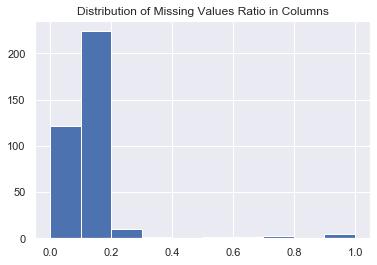

In [23]:
# display distribution of the number of missing values in columns
missing_distribution_plot(azdias_processed, 0)

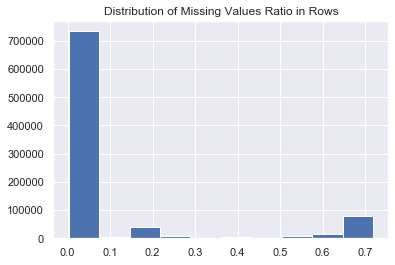

In [24]:
# display distribution of the number of missing values in rows
missing_distribution_plot(azdias_processed, 1)

something about imputer

In [25]:
# replace all NaN values with the mean of values in the same column
imputer = SimpleImputer(missing_values=np.nan , strategy='mean')

# transfer the resulting array to a pandas DataFrame
azdias_processed = pd.DataFrame(imputer.fit_transform(azdias_processed), columns=azdias_processed.columns)

# the shape after replacing
print(azdias_processed.shape)

(891221, 366)


**Function**

In [155]:
def process_missing(df, delRows=True):
    """
    Parameters:
    df: pandas DataFrame, with missing values in columns and rows;
    delRows: boolean, indicates whether rows with too many missing values will be deleted;
    
    Output: DataFrame without missing values
    """
    
    # to be dropped: columns or rows with more than half of the values
    colThreshold = 0.5 * df.shape[0]
    rowThreshold = 0.5 * df.shape[1]
    
    # series of boolean values
    filteredCols = df.isnull().sum(axis=0) < colThreshold
    filteredRows = df.isnull().sum(axis=1) < rowThreshold
    
    # drop columns or rows with too many missing values
    df = df[ filteredCols.index[filteredCols] ]
    if delRows:
        df = df.iloc[ filteredRows.index[filteredRows] ].reset_index(drop=True)
    
    # fill NaNs with imputer
    imputer = SimpleImputer(missing_values=np.nan , strategy='mean')

    # transfer the resulting array to a pandas DataFrame
    cols = list(df.columns)
    df = pd.DataFrame(imputer.fit_transform(df), columns=cols)
    
    return df

**Test**

In [27]:
# the sum of all NaNs in this DataFrame
azdias_processed.isnull().sum(axis=0).sum()

0

In [28]:
azdias_processed

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,910215.0,1.675376,4.421928,15.291805,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.53213,5.945972,4.147141,7.908791,4.052836,3.0,1.0,2.0
1,1.0,910220.0,1.675376,9.000000,15.291805,11.745392,13.402658,14.476013,15.089627,21.000000,...,4.000000,8.000000,11.00000,10.000000,3.000000,9.000000,4.000000,5.0,2.0,1.0
2,2.0,910225.0,1.675376,9.000000,17.000000,11.745392,13.402658,14.476013,15.089627,17.000000,...,2.000000,9.000000,9.00000,6.000000,3.000000,9.000000,2.000000,5.0,2.0,3.0
3,3.0,910226.0,2.000000,1.000000,13.000000,11.745392,13.402658,14.476013,15.089627,13.000000,...,0.000000,7.000000,10.00000,11.000000,4.147141,9.000000,7.000000,3.0,2.0,4.0
4,4.0,910241.0,1.675376,1.000000,20.000000,11.745392,13.402658,14.476013,15.089627,14.000000,...,2.000000,3.000000,5.00000,4.000000,2.000000,9.000000,3.000000,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,891216.0,825761.0,1.675376,5.000000,17.000000,11.745392,13.402658,14.476013,15.089627,17.000000,...,2.000000,4.000000,7.00000,8.000000,3.000000,4.000000,3.000000,4.0,2.0,3.0
891217,891217.0,825771.0,1.675376,9.000000,16.000000,11.745392,13.402658,14.476013,15.089627,16.000000,...,4.000000,6.000000,9.00000,6.000000,6.000000,9.000000,5.000000,6.0,1.0,2.0
891218,891218.0,825772.0,1.675376,1.000000,17.000000,11.745392,13.402658,14.476013,15.089627,17.000000,...,2.000000,7.000000,10.00000,8.000000,4.147141,5.000000,7.000000,4.0,2.0,2.0
891219,891219.0,825776.0,1.675376,9.000000,15.291805,17.000000,13.402658,14.476013,15.089627,20.000000,...,4.000000,9.000000,8.00000,5.000000,1.000000,9.000000,5.000000,5.0,1.0,1.0


### 0-4 Integrated Cleaning Function

Now, all previous steps can be combined together as an integrated function for data cleaning. This function will turn string columns into numerical values, turn numerical missing values into NaNs and drop rows or columns with too many missing values. Finally, reset the index to "LNR", which is the natural index for each individual.

In [156]:
def preprocess(df, delRows=True):
    """
    Parameters:
    df: pandas DataFrame, to be cleaned;
    delRows: boolean, indicates whether rows with too many missing values will be deleted;
    
    Output: the cleaned DataFrame, ready for further analysis
    """
    
    # handle string
    preprocessed_data = process_string(df)
    
    # handle numerical missing values
    preprocessed_data = process_numerical_missing(preprocessed_data)
    
    # handle missing values
    preprocessed_data = process_missing(preprocessed_data, delRows)
    
    # get rid of (possible existing) former index column
    if 'Unnamed: 0' in preprocessed_data.columns:
        preprocessed_data = preprocessed_data.drop(['Unnamed: 0'], axis=1)
    else:
        pass
    
    # reset index as id number
    preprocessed_data["LNR"] = preprocessed_data["LNR"].astype(int)
    preprocessed_data = preprocessed_data.set_index('LNR')
    
    return preprocessed_data

**Test**

In [30]:
# test the cleaning function on another dataset
customers = customers.drop(["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"], axis=1)
customers = preprocess(customers)
print("Sum of missing values in this dataset:", customers.isnull().sum(axis=0).sum(), "\n")
customers.head()

Sum of missing values in this dataset: 0 



,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.000000,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,3.0,5.0,3.0,2.0,6.000000,9.0,7.0,3.0,1.0,4.0
143872,1.573962,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,1.0,0.0,...,4.0,10.0,13.0,11.0,6.000000,9.0,2.0,3.0,2.0,4.0
143873,1.000000,1.0,8.0,8.0,0.0,0.067456,0.0,0.0,1.0,0.0,...,2.0,6.0,4.0,2.0,4.269037,9.0,7.0,1.0,1.0,4.0
143874,1.573962,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,7.0,0.0,...,4.0,3.0,5.0,4.0,2.000000,9.0,3.0,1.0,1.0,3.0
143888,1.000000,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,4.0,1.0,2.0,1.0,6.000000,9.0,1.0,2.0,1.0,3.0


In [31]:
# final step: replace origianl DataFrame and release space
azdias_processed = azdias_processed.drop(['Unnamed: 0'], axis=1)
azdias_processed["LNR"] = azdias_processed["LNR"].astype(int)
azdias_processed = azdias_processed.set_index('LNR')

azdias = azdias_processed
del azdias_processed

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1-1 Correlation Filtering

To begin with, I'll delete columns with high correlation to another, for two reasons: 

1. The following PCA algorithm will reduce the dimension of the feature space, and features with high correlations will be reduced anyway.

2. The azdias dataset is of huge size. Simplify the dataset in advance will improve the running time, especially for possible loops(and there will be). 

In [35]:
# the absolute correlation matrix
corrs = azdias.corr().abs()
corrs

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
AGER_TYP,1.000000,0.018201,0.000114,0.001167,0.001282,0.000653,0.000170,0.011759,0.019810,0.005943,...,0.007079,0.010051,0.017747,0.022601,0.005078,0.012974,0.030780,0.047240,0.021096,0.103487
AKT_DAT_KL,0.018201,1.000000,0.123214,0.008871,0.001053,0.000870,0.000929,0.246539,0.118368,0.027800,...,0.035198,0.376586,0.410553,0.385359,0.071380,0.039801,0.035758,0.174279,0.039133,0.189411
ALTER_HH,0.000114,0.123214,1.000000,0.002698,0.011203,0.004313,0.000357,0.555526,0.044703,0.036816,...,0.037471,0.279403,0.113154,0.054258,0.441440,0.125978,0.042996,0.089372,0.000708,0.370228
ALTER_KIND1,0.001167,0.008871,0.002698,1.000000,0.390850,0.124433,0.041343,0.030305,0.004100,0.000345,...,0.002820,0.012578,0.000890,0.022337,0.001575,0.079335,0.002985,0.018662,0.005234,0.022249
ALTER_KIND2,0.001282,0.001053,0.011203,0.390850,1.000000,0.313248,0.111450,0.014857,0.001184,0.000132,...,0.001097,0.001500,0.002451,0.008107,0.000125,0.031801,0.000396,0.003982,0.002879,0.009519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,0.012974,0.039801,0.125978,0.079335,0.031801,0.006634,0.001289,0.215924,0.050735,0.009779,...,0.030871,0.110732,0.006604,0.127072,0.035079,1.000000,0.031430,0.116417,0.007538,0.164522
WOHNLAGE,0.030780,0.035758,0.042996,0.002985,0.000396,0.003036,0.001696,0.009648,0.082743,0.036593,...,0.079845,0.049095,0.039150,0.033524,0.047768,0.031430,1.000000,0.016857,0.006588,0.015309
ZABEOTYP,0.047240,0.174279,0.089372,0.018662,0.003982,0.001373,0.000080,0.174727,0.172171,0.021018,...,0.047564,0.196308,0.262201,0.292466,0.033128,0.116417,0.016857,1.000000,0.081597,0.172910
ANREDE_KZ,0.021096,0.039133,0.000708,0.005234,0.002879,0.002822,0.000782,0.014955,0.004361,0.006659,...,0.001773,0.003354,0.079220,0.191927,0.079840,0.007538,0.006588,0.081597,1.000000,0.027541


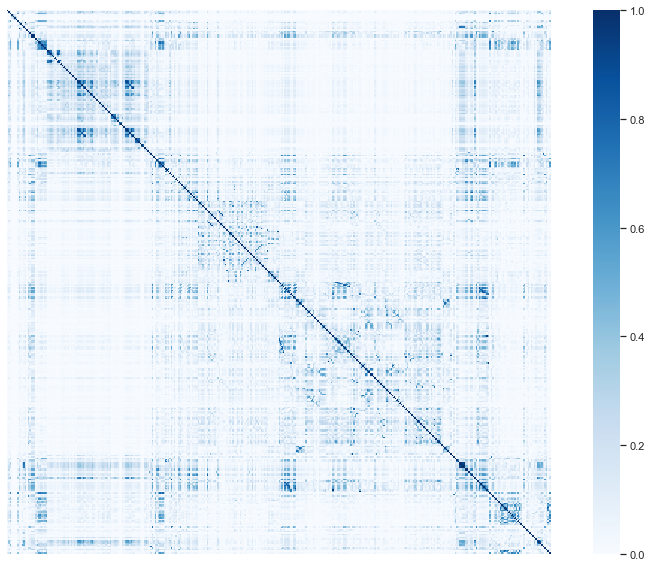

In [53]:
#plot the correlation heatmap 
fig = plt.figure(figsize = (15,10))
sns.heatmap(corrs, vmax=1, vmin=0, xticklabels=False, yticklabels=False, square=True, cmap="Blues")

In [55]:
# The correlation matrix is symmetrical and have ones at diagonal, so take
# the upper triangular area to make every correlation to appear once
corrs_unique = pd.DataFrame(np.triu(corrs, 1), columns=corrs.columns)
corrs_unique

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,0.018201,0.000114,0.001167,0.001282,0.000653,0.000170,0.011759,0.019810,0.005943,...,0.007079,0.010051,0.017747,0.022601,0.005078,0.012974,0.030780,0.047240,0.021096,0.103487
1,0.0,0.000000,0.123214,0.008871,0.001053,0.000870,0.000929,0.246539,0.118368,0.027800,...,0.035198,0.376586,0.410553,0.385359,0.071380,0.039801,0.035758,0.174279,0.039133,0.189411
2,0.0,0.000000,0.000000,0.002698,0.011203,0.004313,0.000357,0.555526,0.044703,0.036816,...,0.037471,0.279403,0.113154,0.054258,0.441440,0.125978,0.042996,0.089372,0.000708,0.370228
3,0.0,0.000000,0.000000,0.000000,0.390850,0.124433,0.041343,0.030305,0.004100,0.000345,...,0.002820,0.012578,0.000890,0.022337,0.001575,0.079335,0.002985,0.018662,0.005234,0.022249
4,0.0,0.000000,0.000000,0.000000,0.000000,0.313248,0.111450,0.014857,0.001184,0.000132,...,0.001097,0.001500,0.002451,0.008107,0.000125,0.031801,0.000396,0.003982,0.002879,0.009519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031430,0.116417,0.007538,0.164522
360,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016857,0.006588,0.015309
361,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081597,0.172910
362,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027541


In [57]:
# list of columns with high correlations
drops = [col for col in corrs.columns if corrs_unique[col].max() > 0.75]

In [58]:
azdias = azdias.drop(drops, axis =1)
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,1.675376,4.421928,15.291805,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,0.040647,...,0.090067,4.58576,1.511166,0.43882,2.417322,6.001214,4.147141,4.052836,3.0,2.0
910220,1.675376,9.000000,15.291805,11.745392,13.402658,14.476013,15.089627,21.000000,11.000000,0.000000,...,1.000000,0.00000,2.000000,0.00000,4.000000,8.000000,3.000000,4.000000,5.0,1.0
910225,1.675376,9.000000,17.000000,11.745392,13.402658,14.476013,15.089627,17.000000,10.000000,0.000000,...,0.000000,1.00000,1.000000,0.00000,2.000000,9.000000,3.000000,2.000000,5.0,3.0
910226,2.000000,1.000000,13.000000,11.745392,13.402658,14.476013,15.089627,13.000000,1.000000,0.000000,...,0.000000,0.00000,1.000000,1.00000,0.000000,7.000000,4.147141,7.000000,3.0,4.0
910241,1.675376,1.000000,20.000000,11.745392,13.402658,14.476013,15.089627,14.000000,3.000000,0.000000,...,0.000000,1.00000,2.000000,0.00000,2.000000,3.000000,2.000000,3.000000,4.0,3.0


In [59]:
# same operation to customer dataset
corrs = customers.corr().abs()
corrs_unique = pd.DataFrame(np.triu(corrs, 1), columns=corrs.columns)
drops = [col for col in corrs.columns if corrs_unique[col].max() > 0.75]
customers = customers.drop(drops, axis =1)
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.000000,1.0,10.0,10.0,1.0,0.000000,0.0,2.0,0.0,1.0,...,8.0,1.0,0.0,3.0,5.0,6.000000,9.0,7.0,3.0,4.0
143872,1.573962,1.0,6.0,0.0,1.0,0.000000,0.0,1.0,0.0,3.0,...,0.0,2.0,0.0,4.0,10.0,6.000000,9.0,2.0,3.0,4.0
143873,1.000000,1.0,8.0,8.0,0.0,0.067456,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,2.0,6.0,4.269037,9.0,7.0,1.0,4.0
143874,1.573962,1.0,20.0,14.0,7.0,0.000000,0.0,4.0,0.0,3.0,...,1.0,2.0,0.0,4.0,3.0,2.000000,9.0,3.0,1.0,3.0
143888,1.000000,1.0,11.0,10.0,1.0,0.000000,0.0,2.0,0.0,3.0,...,24.0,2.0,5.0,4.0,1.0,6.000000,9.0,1.0,2.0,3.0


### 1-2 Feature Normalization

In [61]:
# get common columns of two datasets for comparison
azdias_columns    = azdias.columns
customers_columns = customers.columns
common_columns    = azdias_columns.intersection(customers_columns)

# keep intersected columns only
azdias    = azdias[common_columns]
customers = customers[common_columns]

In [63]:
# use mean_std StandardScaler to normalized data
normalizer = StandardScaler()

# replace the original DataFrame
azdias[azdias.columns] = normalizer.fit_transform(azdias)
customers[customers.columns] = normalizer.fit_transform(customers)

In [64]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-6.108901e-16,-2.548188e-16,1.736716e-15,-8.329672e-16,0.000000,-9.073849e-17,5.767669e-17,-6.016590e-16,1.315086e-17,-1.408128e-15,...,-5.060832e-17,-2.221601e-16,-4.748069e-16,5.068901e-17,-4.095427e-16,3.251332e-16,0.000000,-9.628753e-16,-0.267936,-0.727373
910220,-6.108901e-16,1.313451e+00,1.736716e-15,1.711386e+00,0.183431,-1.328816e-01,-3.200530e-01,2.460008e-01,-6.309721e-02,-1.774118e-01,...,3.318264e+00,-5.735181e-01,1.045294e+00,-4.007008e-01,1.459559e+00,7.316904e-01,-0.704046,-2.863979e-02,1.210585,-1.663024
910225,-6.108901e-16,1.313451e+00,5.566920e-01,7.735480e-01,0.115813,-1.328816e-01,-3.200530e-01,-6.572095e-01,-6.309721e-02,-1.774118e-01,...,-3.284496e-01,-4.484531e-01,-1.093046e+00,-4.007008e-01,-3.848573e-01,1.097758e+00,-0.704046,-1.112741e+00,1.210585,0.208278
910226,8.931071e-01,-9.817530e-01,-7.468871e-01,-1.642896e-01,-0.492754,-1.328816e-01,-3.200530e-01,-1.560420e+00,-6.309721e-02,-1.234353e+00,...,-3.284496e-01,-5.735181e-01,-1.093046e+00,5.124311e-01,-2.229274e+00,3.656229e-01,0.000000,1.597512e+00,-0.267936,1.143930
910241,-6.108901e-16,-9.817530e-01,1.534376e+00,7.016982e-02,-0.357517,-1.328816e-01,-3.200530e-01,2.052422e+00,-6.309721e-02,8.795288e-01,...,-3.284496e-01,-4.484531e-01,1.045294e+00,-4.007008e-01,-3.848573e-01,-1.098647e+00,-1.317786,-5.706904e-01,0.471325,0.208278


In [65]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,0.720148,-0.376898,-0.844677,-0.077671,-0.276260,-0.124391,-0.27585,-0.195728,-0.133733,-1.807095,...,-0.303192,0.319131,-0.997826,-0.659712,0.503966,0.215800,9.454751e-01,1.564723,0.451970,0.659495
143872,0.000000,-0.376898,-1.838972,-2.541652,-0.276260,-0.124391,-0.27585,-0.913752,-0.133733,0.172710,...,-0.303192,-0.547494,1.018872,-0.659712,1.386817,1.931862,9.454751e-01,-0.825712,0.451970,0.659495
143873,-0.970189,-0.376898,-1.341825,-0.570467,-0.346006,0.000000,-0.27585,-1.631776,-0.133733,-1.807095,...,-0.303192,-0.547494,-0.997826,-0.659712,-0.378885,0.559013,-4.851348e-16,1.564723,-1.082199,0.659495
143874,0.000000,-0.376898,1.641062,0.907921,0.142216,-0.124391,-0.27585,1.240321,-0.133733,0.172710,...,-0.303192,-0.439166,1.018872,-0.659712,1.386817,-0.470625,-1.239378e+00,-0.347625,-1.082199,-0.653140
143888,-0.970189,-0.376898,-0.596103,-0.077671,-0.276260,-0.124391,-0.27585,-0.195728,-0.133733,0.172710,...,-0.303192,2.052380,1.018872,3.121290,1.386817,-1.157050,9.454751e-01,-1.303799,-0.315114,-0.653140


   ### 1-3 PCA Analysis

In [66]:
# perform PCA on azdias dataset
pca = PCA().fit(azdias)

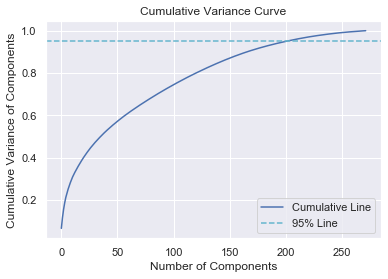

In [67]:
# plot cumulative variance of components
var_ratio = pca.explained_variance_ratio_

# cumulative line and target threshold
plt.plot(np.arange(len(var_ratio)), np.cumsum(var_ratio), label="Cumulative Line")
plt.axhline(y=0.95, ls='--', c='c', label="95% Line")
plt.legend(loc="lower right")

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance of Components")
plt.title("Cumulative Variance Curve")

plt.show()

It's illustrated that 200 components will approximately keep 95 percent of original variance.

In [69]:
# use 200 as threshold to re-run PCA algorithm
pca_azdias = PCA(n_components=200).fit(azdias)
pca_azdias = pd.DataFrame(pca_azdias.transform(azdias))

pca_customers = PCA(n_components=200).fit(customers)
pca_customers = pd.DataFrame(pca_customers.transform(customers))

# print remaining variance
print("remained variance of azdias:", pca_azdias.explained_variance_ratio_.sum(), "\n" 
      "remained variance of customers:", pca_customers.explained_variance_ratio_.sum())

remained variance of azdias: 0.9574344963216024 
remained variance of customers: 0.9437949926283848


### 1-4 K-Means Clustering

In [72]:
# loop to find the best number of clusters
clusters = list(range(1, 21))
dists = []
for i in clusters:
    kmeans = KMeans(i)
    kmeans_azdias = kmeans.fit(pca_azdias)
    dists.append( abs(kmeans_azdias.score(pca_azdias)) )
    print("Cluster", i, "Done")

Cluster 1 Done
Cluster 2 Done
Cluster 3 Done
Cluster 4 Done
Cluster 5 Done
Cluster 6 Done
Cluster 7 Done
Cluster 8 Done
Cluster 9 Done
Cluster 10 Done
Cluster 11 Done
Cluster 12 Done
Cluster 13 Done
Cluster 14 Done
Cluster 15 Done
Cluster 16 Done
Cluster 17 Done
Cluster 18 Done
Cluster 19 Done
Cluster 20 Done


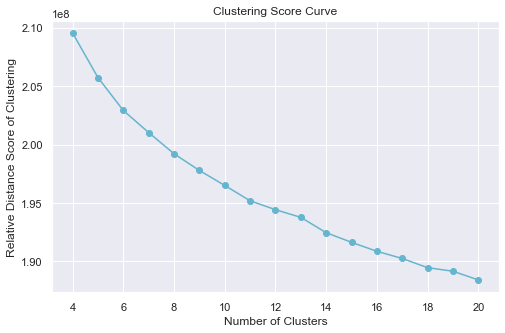

In [83]:
# plot the score curve of different clusters
figure = plt.figure(figsize=(8, 5))
plt.plot(clusters[3:], dists[3:], ls='-', c='c', marker='o')

plt.title("Clustering Score Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Relative Distance Score of Clustering")

Though there's not an explcit "elbow" pattern on the curve, we can see at cluster number of 13, the trend of the curve changed. At numbers less than 13, the slope declines gradually but after 13 the slope seems to decline at a larger rate. This is quite similar to the "elbow" pattern so I choose cluster number of 13 as the final number of clusters.

In [85]:
# refit the model with given threshold
kmeans = KMeans(13)
cluster_azdias = kmeans.fit_predict(pca_azdias)
cluster_customers = kmeans.predict(pca_customers)

In [116]:
# print the number of records in 13 different clusters
_, dist_azdias = np.unique(cluster_azdias, return_counts=True)
_, dist_customers = np.unique(cluster_customers, return_counts=True)
print(dist_azdias)
print(dist_customers)

[ 79033  81977  49030  52355  71174  96096  68226 105787  51428  80185
  57363  82020  16547]
[12920 13403  4399  8712 13858 12576  7998 26238 11540 15325  7432  6148
   317]


In [117]:
# change values to ratios
dist_azdias = dist_azdias / sum(dist_azdias)
dist_customers = dist_customers / sum(dist_customers)

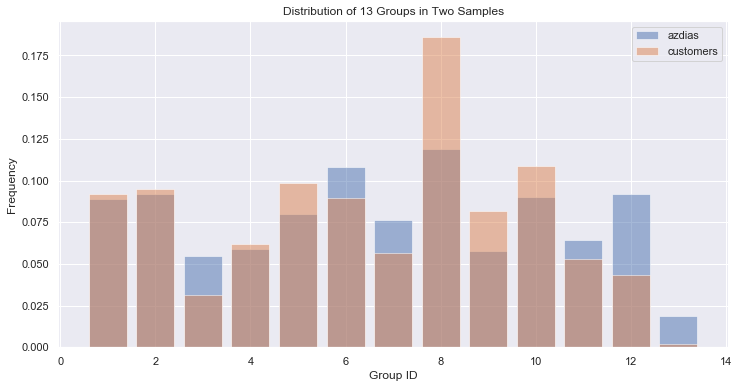

In [132]:
# plot the distribution of different clusters
figure = plt.figure(figsize=(12, 6))
plt.bar(list(range(1, 14)), dist_azdias, alpha=0.5, label="azdias")
plt.bar(list(range(1, 14)), dist_customers, alpha=0.5, label="customers")

plt.title("Distribution of 13 Groups in Two Samples")
plt.xlabel("Group ID")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

From the above distribution, we can see that group 8 has the most potential to become customers and group 3 and 13 are on the contrary. The company can use this result to efficiently acclocate its resources.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [158]:
# install xgboost library
#import sys
#!{sys.executable} -m pip install xgboost -i https://pypi.tuna.tsinghua.edu.cn/simple 

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [123]:
# libraries needed in this part
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# read the data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

### 2-1 Preprocess the Data

In [13]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [14]:
# clean the training set
train = preprocess(mailout_train)

In [15]:
train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1763,2.0,1.0,8.0,8.0,15.0,0.000000,0.0,1.0,13.0,0.0,...,5.0,2.0,1.0,6.000000,9.0,3.0,3.0,0.0,2.0,4.0
1771,1.0,4.0,13.0,13.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,1.0,2.0,1.0,4.000000,9.0,7.0,1.0,0.0,2.0,3.0
1776,1.0,1.0,9.0,7.0,0.0,0.049531,0.0,0.0,1.0,0.0,...,6.0,4.0,2.0,4.603245,9.0,2.0,3.0,0.0,1.0,4.0
1460,2.0,1.0,6.0,6.0,4.0,0.000000,0.0,2.0,4.0,0.0,...,8.0,11.0,11.0,6.000000,9.0,1.0,3.0,0.0,2.0,4.0
1783,2.0,1.0,9.0,9.0,53.0,0.000000,0.0,1.0,44.0,0.0,...,2.0,2.0,1.0,6.000000,9.0,3.0,3.0,0.0,1.0,3.0


In [17]:
# split the training set to features and label
features = train.drop("RESPONSE", axis=1)
label = train["RESPONSE"]

We can see that the positive records are a lot less than negative records, almost 1 out of 100 records is positive.

In [18]:
resp_ratio = sum(label) / len(label)
print("The ratio of positive responses:", resp_ratio)

The ratio of positive responses: 0.012423776144070212


### 2-2 Model Selection

In this section I use the same training an validation sets to decide which model to use. I shall use as more original parameters as possible to evaluate the general performance of basic models. The following function will plot ROC curve as result visualization.

In [19]:
def roc_curve_plot(predict, label, model):
    """
    Parameters:
    predict: array like, predicted probability of label 1;
    label: array like, real label of records;
    model: string, name of the model used here;
    
    Output: ROC curve plot
    """
    
    fpr, tpr, _ = roc_curve(label, predict)
    
    plt.plot(fpr, tpr, c="b")
    plt.plot([0, 1], [0, 1], c="c", ls="--")
    plt.axis([0, 1, 0, 1])
    
    plt.title("ROC Curve of "+ model + " Model")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

#### 2-2-1 Logistic Regression

In [103]:
# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=25)

In [104]:
# logistic regression is a simple model and class weights need to be specifed
model_lr = LogisticRegression(class_weight={0: 0.05, 1: 0.95})
model_lr.fit(X_train, y_train)

c:\users\98269\anaconda3\envs\yusongflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 0.05, 1: 0.95}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# print ROC score on validation set
preds = model_lr.predict_proba(X_val)
preds = preds[:, 1]
print("Validation ROC Score:", np.round(roc_auc_score(y_val, preds), 3))

Validation ROC Score: 0.678


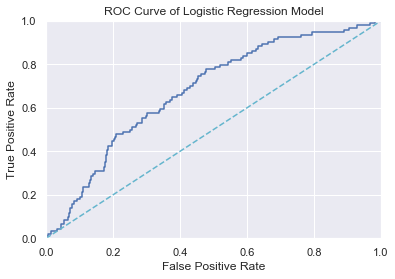

In [106]:
roc_curve_plot(preds, y_val, "Logistic Regression")

#### 2-2-2 Random Forest

In [107]:
# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=25)

In [108]:
# the default number of estimators is too small for this training set
model_rdf = RandomForestRegressor(n_estimators=50, random_state=25)
model_rdf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=25, verbose=0,
                      warm_start=False)

In [109]:
# print ROC score on validation set
preds = model_rdf.predict(X_val)
print("Validation ROC Score:", np.round(roc_auc_score(y_val, preds), 3))

Validation ROC Score: 0.734


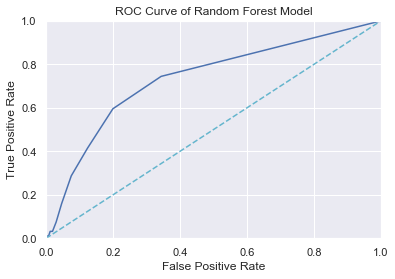

In [110]:
roc_curve_plot(preds, y_val, "Random Forest")

#### 2-2-3  Gradient Boosting

In [111]:
# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=25)

In [112]:
# no other parameters need to be specified
model_gb = GradientBoostingRegressor(random_state=25)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=20, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [113]:
# print ROC score on validation set
preds = model_gb.predict(X_val)
print("Validation ROC Score:", np.round(roc_auc_score(y_val, preds), 3))

Validation ROC Score: 0.747


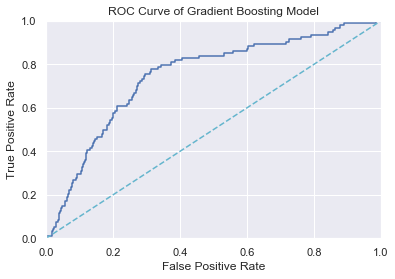

In [114]:
roc_curve_plot(preds, y_val, "Gradient Boosting")

#### 2-2-4 XGBoost

In [118]:
# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=25)

In [119]:
# objective is set for this binary probability regression mission
model_xgb = xgb.XGBRegressor(objective ="binary:logistic", random_state=25)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [120]:
# print ROC score on validation set
preds = model_xgb.predict(X_val)
print("Validation ROC Score:", np.round(roc_auc_score(y_val, preds), 3))

Validation ROC Score: 0.76


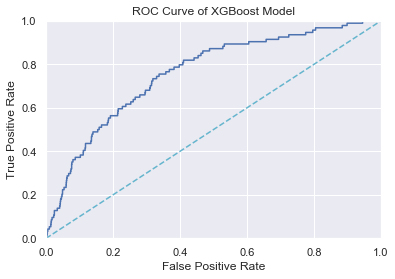

In [121]:
roc_curve_plot(preds, y_val, "XGBoost")

From the initial ROC score on validation sets, XGBoost is choosen as the final model.

### 2-3 Hyperparameter Tuning

For hyperparameter tuning, I will use a different random state to avoid overfitting. Random states are set to make codes verification possible, but using the same random seed through entire learning process may cause overfitting. To address two issues at the same time, different random states are used for different stages.

#### 2-3-1 Initial Search

The first search covers 7 parameters for binary choices. One of the choice is the default value and another is some value nearby. Parameter "n_jobs" are set to use all possible resources to perform multi-threading.

In [166]:
# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=35)

In [170]:
model = xgb.XGBRegressor(random_state=35)

parameters = {"colsample_bytree": [0.8, 1],
              "gamma": [0, 0.2],
              "learning_rate": [0.01, 0.1],
              "max_depth": [5, 10],
              "min_child_weight": [5, 10],
              "n_estimators": [250, 500],
              "objective": ["binary:logistic"],
              "reg_lambda": [1, 1.25]
             }

In [171]:
searcher = GridSearchCV(model, param_grid=parameters, scoring="roc_auc", n_jobs=-1)

In [172]:
grid_search = searcher.fit(X_train, y_train)

c:\users\98269\anaconda3\envs\yusongflow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [184]:
print(grid_search.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'reg_lambda': 1.25}


In [173]:
print("Best ROC Score:", np.round(grid_search.best_score_, 3))

Best ROC Score: 0.773


In [174]:
best_model_xgb = grid_search.best_estimator_
preds = best_model_xgb.predict(X_val)

In [175]:
print("Validation ROC Score:", np.round(roc_auc_score(y_val, preds), 3))

Validation ROC Score: 0.763


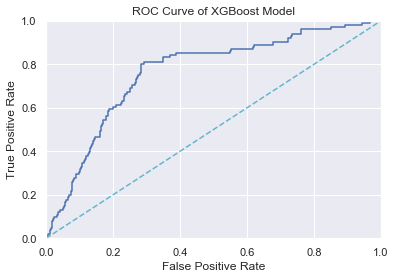

In [176]:
roc_curve_plot(preds, y_val, "XGBoost")

#### 2-3-2 Further Search

Second search covers 4 other parameters to further optimize the above results. Here another random seed is used for the reason mentioned at the beginning of this subsection.

In [203]:
# split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=45)

In [204]:
model = xgb.XGBRegressor(random_state=35)

parameters = {# fixed
              "colsample_bytree": [0.8],
              "learning_rate": [0.01],
              "max_depth": [10],
              "min_child_weight": [5],
              "n_estimators": [500],
              "objective": ["binary:logistic"],
              "reg_lambda": [1.25],
              
              # to be tuned
              "gamma": [0, 0.2],
              "eta": [0.1, 0.3],
              "colsample_bynode": [0.8, 1],
              "reg_alpha": [0, 0.5]
             }

In [205]:
# 3 parallel jobs will be enough
searcher = GridSearchCV(model, param_grid=parameters, scoring="roc_auc", n_jobs=3)

In [206]:
grid_search = searcher.fit(X_train, y_train)

c:\users\98269\anaconda3\envs\yusongflow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [207]:
print(grid_search.best_params_)

{'colsample_bynode': 1, 'colsample_bytree': 0.8, 'eta': 0.1, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'reg_alpha': 0.5, 'reg_lambda': 1.25}


In [208]:
print("Best ROC Score:", np.round(grid_search.best_score_, 3))

Best ROC Score: 0.784


In [209]:
best_model_xgb = grid_search.best_estimator_
preds = best_model_xgb.predict(X_val)

In [210]:
print("Validation ROC Score:", np.round(roc_auc_score(y_val, preds), 3))

Validation ROC Score: 0.789


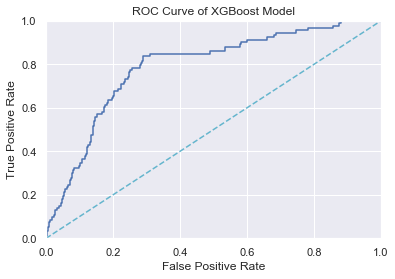

In [211]:
roc_curve_plot(preds, y_val, "XGBoost")

We can see that both the training score and validation score are improving.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [157]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\users\98269\anaconda3\envs\yusongflow\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [158]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [159]:
# clean the test set but do not delete any rows, because all rows need to be evaluated
test = preprocess(mailout_test, delRows=False)
test.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,2.000000,1.0,7.000000,6.0,2.0,0.0,0.0,2.0,2.0,0.0,...,4.0,5.0,6.0,3.0,6.000000,9.0,3.0,3.0,1.0,4.0
1770,1.651514,1.0,12.433248,0.0,20.0,0.0,0.0,1.0,21.0,0.0,...,1.0,5.0,2.0,1.0,6.000000,9.0,5.0,3.0,1.0,4.0
1465,2.000000,9.0,16.000000,11.0,2.0,0.0,0.0,4.0,2.0,0.0,...,3.0,9.0,6.0,3.0,2.000000,9.0,4.0,3.0,2.0,4.0
1470,1.651514,7.0,12.433248,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,2.0,6.0,6.0,3.0,4.587484,9.0,2.0,3.0,2.0,4.0
1478,1.000000,1.0,21.000000,13.0,1.0,0.0,0.0,4.0,1.0,0.0,...,1.0,2.0,4.0,3.0,3.000000,9.0,7.0,4.0,2.0,4.0


In [212]:
# verify the format of prediction values
submission = best_model_xgb.predict(test)
submission

array([0.03746408, 0.02287361, 0.004815  , ..., 0.01595369, 0.02947645,
       0.03037572], dtype=float32)

In [213]:
# turn the array to a DataFrame
submission = pd.DataFrame(index=test.index, data=submission)
submission.rename(columns={0: "RESPONSE"}, inplace=True)

In [214]:
# verify the format of submission file
submission.head()

,RESPONSE
LNR,
1754,0.037464
1770,0.022874
1465,0.004815
1470,0.009565
1478,0.009246


In [215]:
submission.to_csv('submission.csv')